In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

#Feature Selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2

#Models
from sklearn.neighbors import KNeighborsClassifier


%matplotlib inline

In [ ]:
random.seed(42)
np.random.seed(42)

In [ ]:
#Loading Dataset
from google.colab import drive
drive.mount('/content/drive/')
data = pd.read_csv('/content/drive/My Drive/SU/401/CS412/Project/german_credit_data.csv') # enter the file path on your drive for the csv file
data.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [ ]:
#Encoding
data_encoded = data[['Age','Sex','Job','Housing','Saving accounts','Checking account','Credit amount','Duration','Purpose']].copy()
data_encoded['Sex'] = data_encoded['Sex'].replace({'female': 0, 'male': 1},)
data_encoded["Saving accounts"] = data_encoded["Saving accounts"].replace({'little': 0, 'moderate': 1,'quite rich': 2, 'rich': 3})
data_encoded["Housing"]= data_encoded["Housing"].replace({'free':0,'rent':1,'own':2})
data_encoded["Checking account"] = data_encoded["Checking account"].replace({'little': 0, 'moderate': 1, 'rich': 2})
data_encoded["Purpose"]= data_encoded["Purpose"].replace({'car':0,'furniture/equipment':1,'radio/TV':2, 'domestic appliances':3,'repairs':4,'education':5,'business':6,'vacation/others':7})
data_encoded.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,2,NaN,0.0,1169,6,2
1,22,0,2,2,0.0,1.0,5951,48,2
2,49,1,1,2,0.0,NaN,2096,12,5
3,45,1,2,0,0.0,0.0,7882,42,1
4,53,1,2,0,0.0,0.0,4870,24,0


In [ ]:
#Standard Scale and Imputing Data
numeric_cols = list(data_encoded.columns)
df_encoded_scaled = data_encoded.copy()
scaler = StandardScaler()

df_encoded_scaled[numeric_cols] = scaler.fit_transform(df_encoded_scaled[numeric_cols])
imputer = KNNImputer(n_neighbors=5)
data_preprocessed = imputer.fit_transform(df_encoded_scaled)
df = pd.DataFrame(data_preprocessed)
df.rename(columns = {0:'Age', 1:'Sex', 2:'Job',	3:'Housing',	4:'Saving accounts',	5:'Checking account',	6:'Credit amount', 7:	'Duration', 8:	'Purpose'}, inplace = True)

In [ ]:
X = df
y = data["Risk"]

# Feature Selection

## PCA

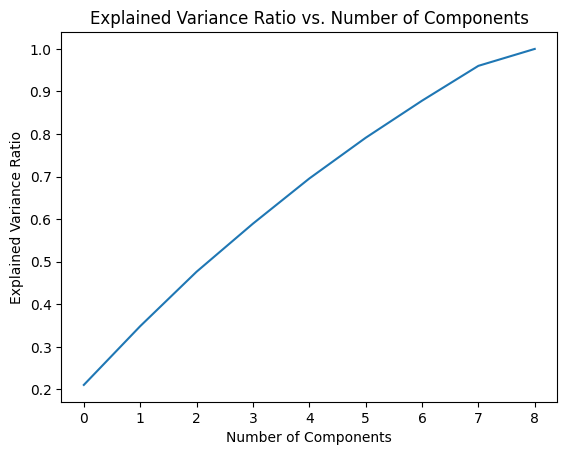

In [ ]:
#Principal Component Analysis
X_std = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
# Perform PCA with a range of components
pca = PCA()
pca.fit(X_std)
explained_variance_ratio = pca.explained_variance_ratio_
# Plot the explained variance ratio
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.show()

# Models

###PCA with 2 components

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
#train-val-test split
#using stratify since data is imbalanced
X_training, X_test, y_training, y_test = train_test_split(X_pca, y, test_size = 0.2, stratify=y, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size = 0.2, stratify=y_training, random_state = 42)

## K-Nearest Neighbors (KNN)

In [ ]:
#kNN Classifier
k_values = [1, 3, 5, 7, 9, 11, 12, 13, 14, 15, 16, 17, 19, 21, 23]   
best_acc = -1 
best_k = None
val_accs = [] 
for k in k_values:
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X_val, y_val)
  scores = cross_val_score(neigh, X_val, y_val, cv=5, scoring='accuracy')
  acc=scores.mean()
  if acc > best_acc:
    best_acc = acc
    best_k = k
print('Best validation accuracy (', best_acc, ') is achieved with k =', best_k)
best_neigh = KNeighborsClassifier(n_neighbors=best_k)
best_neigh.fit(X_train,y_train)
y_pred = best_neigh.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print('Test accuracy is ', acc)

Best validation accuracy ( 0.7 ) is achieved with k = 15
Test accuracy is  0.72


## Decision Tree (DT)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Define the parameter values to try
max_depth = [3, 5, 10]
min_samples_split = [2, 5, 10]
criterion = ['gini','entropy']

best_score = 0
best_params = {}

# Iterate over each combination of hyperparameters
for depth in max_depth:
    for split in min_samples_split:
      for crit in criterion:
          dtc = DecisionTreeClassifier(max_depth=depth, min_samples_split=split, criterion = crit)

          # Perform 5-fold cross-validation
          scores = cross_val_score(dtc, X_train, y_train, cv=5)
          
          # Calculate the mean cross-validation score
          mean_score = scores.mean()

          if mean_score > best_score:
              best_score = mean_score
              best_params = {'max_depth': depth, 'min_samples_split': split ,'criterion' : crit }

best_dtc = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'],criterion=best_params['criterion'])
best_dtc.fit(X_train, y_train)

# Evaluate the model performance on the test set
accuracy = best_dtc.score(X_test, y_test)

# Print the best hyperparameters and the test set performance
print('Best validation accuracy (', best_score, ') is achieved with hyperparameters:', best_params)
print("Test Set Accuracy:", accuracy)

Best validation accuracy ( 0.7203125 ) is achieved with hyperparameters: {'max_depth': 3, 'min_samples_split': 2, 'criterion': 'gini'}
Test Set Accuracy: 0.7


## Logistic Regression (LR)

In [ ]:
from sklearn.linear_model import LogisticRegression

max_iter = [1000,10000]
C = [0.01, 0.1, 1, 10, 100,1000]
solver = ['liblinear','lbfgs','newton-cg']

best_score = 0
best_params = {}

# Iterate over each combination of hyperparameters
for iter in max_iter:
    for c in C:
      for solv in solver:
          logr = LogisticRegression(max_iter=iter, C=c, solver = solv)

          # Perform 5-fold cross-validation
          scores = cross_val_score(logr, X_train, y_train, cv=5)
          
          # Calculate the mean cross-validation score
          mean_score = scores.mean()

          if mean_score > best_score:
              best_score = mean_score
              best_params = {'max_iter': iter, 'C': c,'solver' : solv }

best_logr = LogisticRegression(max_iter=best_params['max_iter'], C=best_params['C'],solver=best_params['solver'])
best_logr.fit(X_train, y_train)

# Evaluate the model performance on the test set
accuracy = best_logr.score(X_test, y_test)

# Print the best hyperparameters and the test set performance
print('Best validation accuracy (', best_score, ') is achieved with hyperparameters:', best_params)
print("Test Set Accuracy:", accuracy)

Best validation accuracy ( 0.715625 ) is achieved with hyperparameters: {'max_iter': 1000, 'C': 0.1, 'solver': 'liblinear'}
Test Set Accuracy: 0.7


## Support Vector Machines (SVM)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# Define the parameter values to try
C_values = [0.1, 1, 10,100]
kernel_values = ['linear', 'poly', 'rbf']

best_score = 0
best_params = {}

# Iterate over each combination of hyperparameters
for C in C_values:
    for kernel in kernel_values:
        # Initialize the SVM classifier with the current hyperparameters
        svm = SVC(C=C, kernel=kernel)

        # Perform 5-fold cross-validation
        scores = cross_val_score(svm, X_val, y_val, cv=5)

        # Calculate the mean cross-validation score
        mean_score = scores.mean()

        # Check if the current hyperparameters yield a better score
        if mean_score > best_score:
            best_score = mean_score
            best_params = {'C': C, 'kernel': kernel}

# Train the final SVM model with the best hyperparameters on the entire training set
best_svm = SVC(C=best_params['C'], kernel=best_params['kernel'])
best_svm.fit(X_train, y_train)

from sklearn import metrics
y_pred = best_svm.predict(X_test)
# Model Accuracy: how often is the classifier correct?
# Print the best hyperparameters and the test set performance
print('Best validation accuracy (', best_score, ') is achieved with hyperparameters:', best_params)
print("Test Set Accuracy:", accuracy)

Best validation accuracy ( 0.7 ) is achieved with hyperparameters: {'C': 0.1, 'kernel': 'linear'}
Test Set Accuracy: 0.7


# Models

###PCA with 5 components

In [ ]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)
#train-val-test split
#using stratify since data is imbalanced
X_training, X_test, y_training, y_test = train_test_split(X_pca, y, test_size = 0.2, stratify=y, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size = 0.2, stratify=y_training, random_state = 42)

## K-Nearest Neighbors (KNN)

In [ ]:
#kNN Classifier
k_values = [1, 3, 5, 7, 9, 11, 12, 13, 14, 15, 16, 17, 19, 21, 23]   
best_acc = -1 
best_k = None
val_accs = [] 
for k in k_values:
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X_val, y_val)
  scores = cross_val_score(neigh, X_val, y_val, cv=5, scoring='accuracy')
  acc=scores.mean()
  if acc > best_acc:
    best_acc = acc
    best_k = k
print('Best validation accuracy (', best_acc, ') is achieved with k =', best_k)
best_neigh = KNeighborsClassifier(n_neighbors=best_k)
best_neigh.fit(X_train,y_train)
y_pred = best_neigh.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print('Test accuracy is ', acc)

Best validation accuracy ( 0.7 ) is achieved with k = 12
Test accuracy is  0.685


## Decision Tree (DT)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Define the parameter values to try
max_depth = [3, 5, 10]
min_samples_split = [2, 5, 10]
criterion = ['gini','entropy']

best_score = 0
best_params = {}

# Iterate over each combination of hyperparameters
for depth in max_depth:
    for split in min_samples_split:
      for crit in criterion:
          dtc = DecisionTreeClassifier(max_depth=depth, min_samples_split=split, criterion = crit)

          # Perform 5-fold cross-validation
          scores = cross_val_score(dtc, X_train, y_train, cv=5)
          
          # Calculate the mean cross-validation score
          mean_score = scores.mean()

          if mean_score > best_score:
              best_score = mean_score
              best_params = {'max_depth': depth, 'min_samples_split': split ,'criterion' : crit }

best_dtc = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'],criterion=best_params['criterion'])
best_dtc.fit(X_train, y_train)

# Evaluate the model performance on the test set
accuracy = best_dtc.score(X_test, y_test)

# Print the best hyperparameters and the test set performance
print('Best validation accuracy (', best_score, ') is achieved with hyperparameters:', best_params)
print("Test Set Accuracy:", accuracy)

Best validation accuracy ( 0.70625 ) is achieved with hyperparameters: {'max_depth': 3, 'min_samples_split': 5, 'criterion': 'entropy'}
Test Set Accuracy: 0.685


## Logistic Regression (LR)

In [ ]:
from sklearn.linear_model import LogisticRegression

max_iter = [1000,10000]
C = [0.01, 0.1, 1, 10, 100,1000]
solver = ['liblinear','lbfgs','newton-cg']

best_score = 0
best_params = {}

# Iterate over each combination of hyperparameters
for iter in max_iter:
    for c in C:
      for solv in solver:
          logr = LogisticRegression(max_iter=iter, C=c, solver = solv)

          # Perform 5-fold cross-validation
          scores = cross_val_score(logr, X_train, y_train, cv=5)
          
          # Calculate the mean cross-validation score
          mean_score = scores.mean()

          if mean_score > best_score:
              best_score = mean_score
              best_params = {'max_iter': iter, 'C': c,'solver' : solv }

best_logr = LogisticRegression(max_iter=best_params['max_iter'], C=best_params['C'],solver=best_params['solver'])
best_logr.fit(X_train, y_train)

# Evaluate the model performance on the test set
accuracy = best_logr.score(X_test, y_test)

# Print the best hyperparameters and the test set performance
print('Best validation accuracy (', best_score, ') is achieved with hyperparameters:', best_params)
print("Test Set Accuracy:", accuracy)

Best validation accuracy ( 0.7234375 ) is achieved with hyperparameters: {'max_iter': 1000, 'C': 0.1, 'solver': 'liblinear'}
Test Set Accuracy: 0.715


## Support Vector Machines (SVM)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# Define the parameter values to try
C_values = [0.1, 1, 10,100]
kernel_values = ['linear', 'poly', 'rbf']

best_score = 0
best_params = {}

# Iterate over each combination of hyperparameters
for C in C_values:
    for kernel in kernel_values:
        # Initialize the SVM classifier with the current hyperparameters
        svm = SVC(C=C, kernel=kernel)

        # Perform 5-fold cross-validation
        scores = cross_val_score(svm, X_val, y_val, cv=5)

        # Calculate the mean cross-validation score
        mean_score = scores.mean()

        # Check if the current hyperparameters yield a better score
        if mean_score > best_score:
            best_score = mean_score
            best_params = {'C': C, 'kernel': kernel}

# Train the final SVM model with the best hyperparameters on the entire training set
best_svm = SVC(C=best_params['C'], kernel=best_params['kernel'])
best_svm.fit(X_train, y_train)

from sklearn import metrics
y_pred = best_svm.predict(X_test)
# Model Accuracy: how often is the classifier correct?
# Print the best hyperparameters and the test set performance
print('Best validation accuracy (', best_score, ') is achieved with hyperparameters:', best_params)
print("Test Set Accuracy:", accuracy)

Best validation accuracy ( 0.7125 ) is achieved with hyperparameters: {'C': 1, 'kernel': 'linear'}
Test Set Accuracy: 0.715


# Models

###PCA with 7 components

In [ ]:
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)
#train-val-test split
#using stratify since data is imbalanced
X_training, X_test, y_training, y_test = train_test_split(X_pca, y, test_size = 0.2, stratify=y, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size = 0.2, stratify=y_training, random_state = 42)

## K-Nearest Neighbors (KNN)

In [ ]:
#kNN Classifier
k_values = [1, 3, 5, 7, 9, 11, 12, 13, 14, 15, 16, 17, 19, 21, 23]   
best_acc = -1 
best_k = None
val_accs = [] 
for k in k_values:
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X_val, y_val)
  scores = cross_val_score(neigh, X_val, y_val, cv=5, scoring='accuracy')
  acc=scores.mean()
  if acc > best_acc:
    best_acc = acc
    best_k = k
print('Best validation accuracy (', best_acc, ') is achieved with k =', best_k)
best_neigh = KNeighborsClassifier(n_neighbors=best_k)
best_neigh.fit(X_train,y_train)
y_pred = best_neigh.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print('Test accuracy is ', acc)

Best validation accuracy ( 0.7125 ) is achieved with k = 21
Test accuracy is  0.675


## Decision Tree (DT)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Define the parameter values to try
max_depth = [3, 5, 10]
min_samples_split = [2, 5, 10]
criterion = ['gini','entropy']

best_score = 0
best_params = {}

# Iterate over each combination of hyperparameters
for depth in max_depth:
    for split in min_samples_split:
      for crit in criterion:
          dtc = DecisionTreeClassifier(max_depth=depth, min_samples_split=split, criterion = crit)

          # Perform 5-fold cross-validation
          scores = cross_val_score(dtc, X_train, y_train, cv=5)
          
          # Calculate the mean cross-validation score
          mean_score = scores.mean()

          if mean_score > best_score:
              best_score = mean_score
              best_params = {'max_depth': depth, 'min_samples_split': split ,'criterion' : crit }

best_dtc = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'],criterion=best_params['criterion'])
best_dtc.fit(X_train, y_train)

# Evaluate the model performance on the test set
accuracy = best_dtc.score(X_test, y_test)

# Print the best hyperparameters and the test set performance
print('Best validation accuracy (', best_score, ') is achieved with hyperparameters:', best_params)
print("Test Set Accuracy:", accuracy)

Best validation accuracy ( 0.7078125 ) is achieved with hyperparameters: {'max_depth': 3, 'min_samples_split': 10, 'criterion': 'entropy'}
Test Set Accuracy: 0.685


## Logistic Regression (LR)

In [ ]:
from sklearn.linear_model import LogisticRegression

max_iter = [1000,10000]
C = [0.01, 0.1, 1, 10, 100,1000]
solver = ['liblinear','lbfgs','newton-cg']

best_score = 0
best_params = {}

# Iterate over each combination of hyperparameters
for iter in max_iter:
    for c in C:
      for solv in solver:
          logr = LogisticRegression(max_iter=iter, C=c, solver = solv)

          # Perform 5-fold cross-validation
          scores = cross_val_score(logr, X_train, y_train, cv=5)
          
          # Calculate the mean cross-validation score
          mean_score = scores.mean()

          if mean_score > best_score:
              best_score = mean_score
              best_params = {'max_iter': iter, 'C': c,'solver' : solv }

best_logr = LogisticRegression(max_iter=best_params['max_iter'], C=best_params['C'],solver=best_params['solver'])
best_logr.fit(X_train, y_train)

# Evaluate the model performance on the test set
accuracy = best_logr.score(X_test, y_test)

# Print the best hyperparameters and the test set performance
print('Best validation accuracy (', best_score, ') is achieved with hyperparameters:', best_params)
print("Test Set Accuracy:", accuracy)

Best validation accuracy ( 0.7296875 ) is achieved with hyperparameters: {'max_iter': 1000, 'C': 0.1, 'solver': 'liblinear'}
Test Set Accuracy: 0.705


## Support Vector Machines (SVM)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# Define the parameter values to try
C_values = [0.1, 1, 10,100]
kernel_values = ['linear', 'poly', 'rbf']

best_score = 0
best_params = {}

# Iterate over each combination of hyperparameters
for C in C_values:
    for kernel in kernel_values:
        # Initialize the SVM classifier with the current hyperparameters
        svm = SVC(C=C, kernel=kernel)

        # Perform 5-fold cross-validation
        scores = cross_val_score(svm, X_val, y_val, cv=5)

        # Calculate the mean cross-validation score
        mean_score = scores.mean()

        # Check if the current hyperparameters yield a better score
        if mean_score > best_score:
            best_score = mean_score
            best_params = {'C': C, 'kernel': kernel}

# Train the final SVM model with the best hyperparameters on the entire training set
best_svm = SVC(C=best_params['C'], kernel=best_params['kernel'])
best_svm.fit(X_train, y_train)

from sklearn import metrics
y_pred = best_svm.predict(X_test)
# Model Accuracy: how often is the classifier correct?
# Print the best hyperparameters and the test set performance
print('Best validation accuracy (', best_score, ') is achieved with hyperparameters:', best_params)
print("Test Set Accuracy:", accuracy)

Best validation accuracy ( 0.7 ) is achieved with hyperparameters: {'C': 0.1, 'kernel': 'linear'}
Test Set Accuracy: 0.705


# Models

In [ ]:
#MinMaxScale and Imputing Data (Since K best does not work with negative data)
numeric_cols = list(data_encoded.columns)
df_encoded_scaled = data_encoded.copy()
scaler = MinMaxScaler()

df_encoded_scaled[numeric_cols] = scaler.fit_transform(df_encoded_scaled[numeric_cols])
imputer = KNNImputer(n_neighbors=5)
data_preprocessed = imputer.fit_transform(df_encoded_scaled)
df = pd.DataFrame(data_preprocessed)
df.rename(columns = {0:'Age', 1:'Sex', 2:'Job',	3:'Housing',	4:'Saving accounts',	5:'Checking account',	6:'Credit amount', 7:	'Duration', 8:	'Purpose'}, inplace = True)
X = df
y = data["Risk"]

###Select K (2) Best Using Chi-Squared

In [ ]:
#Feature selection using chi-squared test
selector = SelectKBest(score_func=chi2, k=2)  
X_selected = selector.fit_transform(X, y)
X_training, X_test, y_training, y_test = train_test_split(X_selected, y, test_size = 0.2, stratify=y, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size = 0.2, stratify=y_training, random_state = 42)

## K-Nearest Neighbors (KNN)

In [ ]:
#kNN Classifier
k_values = [1, 3, 5, 7, 9, 11, 12, 13, 14, 15, 16, 17, 19, 21, 23]   
best_acc = -1 
best_k = None
val_accs = [] 
for k in k_values:
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X_val, y_val)
  scores = cross_val_score(neigh, X_val, y_val, cv=5, scoring='accuracy')
  acc=scores.mean()
  if acc > best_acc:
    best_acc = acc
    best_k = k
print('Best validation accuracy (', best_acc, ') is achieved with k =', best_k)
best_neigh = KNeighborsClassifier(n_neighbors=best_k)
best_neigh.fit(X_train,y_train)
y_pred = best_neigh.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print('Test accuracy is ', acc)

Best validation accuracy ( 0.7 ) is achieved with k = 19
Test accuracy is  0.715


## Decision Tree (DT)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Define the parameter values to try
max_depth = [3, 5, 10]
min_samples_split = [2, 5, 10]
criterion = ['gini','entropy']

best_score = 0
best_params = {}

# Iterate over each combination of hyperparameters
for depth in max_depth:
    for split in min_samples_split:
      for crit in criterion:
          dtc = DecisionTreeClassifier(max_depth=depth, min_samples_split=split, criterion = crit)

          # Perform 5-fold cross-validation
          scores = cross_val_score(dtc, X_train, y_train, cv=5)
          
          # Calculate the mean cross-validation score
          mean_score = scores.mean()

          if mean_score > best_score:
              best_score = mean_score
              best_params = {'max_depth': depth, 'min_samples_split': split ,'criterion' : crit }

best_dtc = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'],criterion=best_params['criterion'])
best_dtc.fit(X_train, y_train)

# Evaluate the model performance on the test set
accuracy = best_dtc.score(X_test, y_test)

# Print the best hyperparameters and the test set performance
print('Best validation accuracy (', best_score, ') is achieved with hyperparameters:', best_params)
print("Test Set Accuracy:", accuracy)

Best validation accuracy ( 0.71875 ) is achieved with hyperparameters: {'max_depth': 3, 'min_samples_split': 2, 'criterion': 'entropy'}
Test Set Accuracy: 0.71


## Logistic Regression (LR)

In [ ]:
from sklearn.linear_model import LogisticRegression

max_iter = [1000,10000]
C = [0.01, 0.1, 1, 10, 100,1000]
solver = ['liblinear','lbfgs','newton-cg']

best_score = 0
best_params = {}

# Iterate over each combination of hyperparameters
for iter in max_iter:
    for c in C:
      for solv in solver:
          logr = LogisticRegression(max_iter=iter, C=c, solver = solv)

          # Perform 5-fold cross-validation
          scores = cross_val_score(logr, X_train, y_train, cv=5)
          
          # Calculate the mean cross-validation score
          mean_score = scores.mean()

          if mean_score > best_score:
              best_score = mean_score
              best_params = {'max_iter': iter, 'C': c,'solver' : solv }

best_logr = LogisticRegression(max_iter=best_params['max_iter'], C=best_params['C'],solver=best_params['solver'])
best_logr.fit(X_train, y_train)

# Evaluate the model performance on the test set
accuracy = best_logr.score(X_test, y_test)

# Print the best hyperparameters and the test set performance
print('Best validation accuracy (', best_score, ') is achieved with hyperparameters:', best_params)
print("Test Set Accuracy:", accuracy)

Best validation accuracy ( 0.7203125 ) is achieved with hyperparameters: {'max_iter': 1000, 'C': 1, 'solver': 'liblinear'}
Test Set Accuracy: 0.7


## Support Vector Machines (SVM)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# Define the parameter values to try
C_values = [0.1, 1, 10,100]
kernel_values = ['linear', 'poly', 'rbf']

best_score = 0
best_params = {}

# Iterate over each combination of hyperparameters
for C in C_values:
    for kernel in kernel_values:
        # Initialize the SVM classifier with the current hyperparameters
        svm = SVC(C=C, kernel=kernel)

        # Perform 5-fold cross-validation
        scores = cross_val_score(svm, X_val, y_val, cv=5)

        # Calculate the mean cross-validation score
        mean_score = scores.mean()

        # Check if the current hyperparameters yield a better score
        if mean_score > best_score:
            best_score = mean_score
            best_params = {'C': C, 'kernel': kernel}

# Train the final SVM model with the best hyperparameters on the entire training set
best_svm = SVC(C=best_params['C'], kernel=best_params['kernel'])
best_svm.fit(X_train, y_train)

from sklearn import metrics
y_pred = best_svm.predict(X_test)
# Model Accuracy: how often is the classifier correct?
# Print the best hyperparameters and the test set performance
print('Best validation accuracy (', best_score, ') is achieved with hyperparameters:', best_params)
print("Test Set Accuracy:", accuracy)

Best validation accuracy ( 0.70625 ) is achieved with hyperparameters: {'C': 10, 'kernel': 'rbf'}
Test Set Accuracy: 0.7


# Models

###Select K (5) Best Using Chi-Squared

In [ ]:
#Feature selection using chi-squared test
selector = SelectKBest(score_func=chi2, k=5)  
X_selected = selector.fit_transform(X, y)
X_training, X_test, y_training, y_test = train_test_split(X_selected, y, test_size = 0.2, stratify=y, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size = 0.2, stratify=y_training, random_state = 42)

## K-Nearest Neighbors (KNN)

In [ ]:
#kNN Classifier
k_values = [1, 3, 5, 7, 9, 11, 12, 13, 14, 15, 16, 17, 19, 21, 23]   
best_acc = -1 
best_k = None
val_accs = [] 
for k in k_values:
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X_val, y_val)
  scores = cross_val_score(neigh, X_val, y_val, cv=5, scoring='accuracy')
  acc=scores.mean()
  if acc > best_acc:
    best_acc = acc
    best_k = k
print('Best validation accuracy (', best_acc, ') is achieved with k =', best_k)
best_neigh = KNeighborsClassifier(n_neighbors=best_k)
best_neigh.fit(X_train,y_train)
y_pred = best_neigh.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print('Test accuracy is ', acc)

Best validation accuracy ( 0.75 ) is achieved with k = 13
Test accuracy is  0.76


## Decision Tree (DT)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Define the parameter values to try
max_depth = [3, 5, 10]
min_samples_split = [2, 5, 10]
criterion = ['gini','entropy']

best_score = 0
best_params = {}

# Iterate over each combination of hyperparameters
for depth in max_depth:
    for split in min_samples_split:
      for crit in criterion:
          dtc = DecisionTreeClassifier(max_depth=depth, min_samples_split=split, criterion = crit)

          # Perform 5-fold cross-validation
          scores = cross_val_score(dtc, X_train, y_train, cv=5)
          
          # Calculate the mean cross-validation score
          mean_score = scores.mean()

          if mean_score > best_score:
              best_score = mean_score
              best_params = {'max_depth': depth, 'min_samples_split': split ,'criterion' : crit }

best_dtc = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'],criterion=best_params['criterion'])
best_dtc.fit(X_train, y_train)

# Evaluate the model performance on the test set
accuracy = best_dtc.score(X_test, y_test)

# Print the best hyperparameters and the test set performance
print('Best validation accuracy (', best_score, ') is achieved with hyperparameters:', best_params)
print("Test Set Accuracy:", accuracy)

Best validation accuracy ( 0.725 ) is achieved with hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'criterion': 'gini'}
Test Set Accuracy: 0.715


## Logistic Regression (LR)

In [ ]:
from sklearn.linear_model import LogisticRegression

max_iter = [1000,10000]
C = [0.01, 0.1, 1, 10, 100,1000]
solver = ['liblinear','lbfgs','newton-cg']

best_score = 0
best_params = {}

# Iterate over each combination of hyperparameters
for iter in max_iter:
    for c in C:
      for solv in solver:
          logr = LogisticRegression(max_iter=iter, C=c, solver = solv)

          # Perform 5-fold cross-validation
          scores = cross_val_score(logr, X_train, y_train, cv=5)
          
          # Calculate the mean cross-validation score
          mean_score = scores.mean()

          if mean_score > best_score:
              best_score = mean_score
              best_params = {'max_iter': iter, 'C': c,'solver' : solv }

best_logr = LogisticRegression(max_iter=best_params['max_iter'], C=best_params['C'],solver=best_params['solver'])
best_logr.fit(X_train, y_train)

# Evaluate the model performance on the test set
accuracy = best_logr.score(X_test, y_test)

# Print the best hyperparameters and the test set performance
print('Best validation accuracy (', best_score, ') is achieved with hyperparameters:', best_params)
print("Test Set Accuracy:", accuracy)

Best validation accuracy ( 0.7109375 ) is achieved with hyperparameters: {'max_iter': 1000, 'C': 1, 'solver': 'liblinear'}
Test Set Accuracy: 0.7


## Support Vector Machines (SVM)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# Define the parameter values to try
C_values = [0.1, 1, 10,100]
kernel_values = ['linear', 'poly', 'rbf']

best_score = 0
best_params = {}

# Iterate over each combination of hyperparameters
for C in C_values:
    for kernel in kernel_values:
        # Initialize the SVM classifier with the current hyperparameters
        svm = SVC(C=C, kernel=kernel)

        # Perform 5-fold cross-validation
        scores = cross_val_score(svm, X_val, y_val, cv=5)

        # Calculate the mean cross-validation score
        mean_score = scores.mean()

        # Check if the current hyperparameters yield a better score
        if mean_score > best_score:
            best_score = mean_score
            best_params = {'C': C, 'kernel': kernel}

# Train the final SVM model with the best hyperparameters on the entire training set
best_svm = SVC(C=best_params['C'], kernel=best_params['kernel'])
best_svm.fit(X_train, y_train)

from sklearn import metrics
y_pred = best_svm.predict(X_test)
# Model Accuracy: how often is the classifier correct?
# Print the best hyperparameters and the test set performance
print('Best validation accuracy (', best_score, ') is achieved with hyperparameters:', best_params)
print("Test Set Accuracy:", accuracy)

Best validation accuracy ( 0.75 ) is achieved with hyperparameters: {'C': 10, 'kernel': 'rbf'}
Test Set Accuracy: 0.7


# Models

###Select K (7) Best Using Chi-Squared

In [ ]:
#Feature selection using chi-squared test
selector = SelectKBest(score_func=chi2, k=7)  
X_selected = selector.fit_transform(X, y)
X_training, X_test, y_training, y_test = train_test_split(X_selected, y, test_size = 0.2, stratify=y, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size = 0.2, stratify=y_training, random_state = 42)

## K-Nearest Neighbors (KNN)

In [ ]:
#kNN Classifier
k_values = [1, 3, 5, 7, 9, 11, 12, 13, 14, 15, 16, 17, 19, 21, 23]   
best_acc = -1 
best_k = None
val_accs = [] 
for k in k_values:
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X_val, y_val)
  scores = cross_val_score(neigh, X_val, y_val, cv=5, scoring='accuracy')
  acc=scores.mean()
  if acc > best_acc:
    best_acc = acc
    best_k = k
print('Best validation accuracy (', best_acc, ') is achieved with k =', best_k)
best_neigh = KNeighborsClassifier(n_neighbors=best_k)
best_neigh.fit(X_train,y_train)
y_pred = best_neigh.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print('Test accuracy is ', acc)

Best validation accuracy ( 0.73125 ) is achieved with k = 7
Test accuracy is  0.68


## Decision Tree (DT)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Define the parameter values to try
max_depth = [3, 5, 10]
min_samples_split = [2, 5, 10]
criterion = ['gini','entropy']

best_score = 0
best_params = {}

# Iterate over each combination of hyperparameters
for depth in max_depth:
    for split in min_samples_split:
      for crit in criterion:
          dtc = DecisionTreeClassifier(max_depth=depth, min_samples_split=split, criterion = crit)

          # Perform 5-fold cross-validation
          scores = cross_val_score(dtc, X_train, y_train, cv=5)
          
          # Calculate the mean cross-validation score
          mean_score = scores.mean()

          if mean_score > best_score:
              best_score = mean_score
              best_params = {'max_depth': depth, 'min_samples_split': split ,'criterion' : crit }

best_dtc = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'],criterion=best_params['criterion'])
best_dtc.fit(X_train, y_train)

# Evaluate the model performance on the test set
accuracy = best_dtc.score(X_test, y_test)

# Print the best hyperparameters and the test set performance
print('Best validation accuracy (', best_score, ') is achieved with hyperparameters:', best_params)
print("Test Set Accuracy:", accuracy)

Best validation accuracy ( 0.728125 ) is achieved with hyperparameters: {'max_depth': 5, 'min_samples_split': 2, 'criterion': 'gini'}
Test Set Accuracy: 0.725


## Logistic Regression (LR)

In [ ]:
from sklearn.linear_model import LogisticRegression

max_iter = [1000,10000]
C = [0.01, 0.1, 1, 10, 100,1000]
solver = ['liblinear','lbfgs','newton-cg']

best_score = 0
best_params = {}

# Iterate over each combination of hyperparameters
for iter in max_iter:
    for c in C:
      for solv in solver:
          logr = LogisticRegression(max_iter=iter, C=c, solver = solv)

          # Perform 5-fold cross-validation
          scores = cross_val_score(logr, X_train, y_train, cv=5)
          
          # Calculate the mean cross-validation score
          mean_score = scores.mean()

          if mean_score > best_score:
              best_score = mean_score
              best_params = {'max_iter': iter, 'C': c,'solver' : solv }

best_logr = LogisticRegression(max_iter=best_params['max_iter'], C=best_params['C'],solver=best_params['solver'])
best_logr.fit(X_train, y_train)

# Evaluate the model performance on the test set
accuracy = best_logr.score(X_test, y_test)

# Print the best hyperparameters and the test set performance
print('Best validation accuracy (', best_score, ') is achieved with hyperparameters:', best_params)
print("Test Set Accuracy:", accuracy)

Best validation accuracy ( 0.7234375 ) is achieved with hyperparameters: {'max_iter': 1000, 'C': 10, 'solver': 'liblinear'}
Test Set Accuracy: 0.705


## Support Vector Machines (SVM)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# Define the parameter values to try
C_values = [0.1, 1, 10,100]
kernel_values = ['linear', 'poly', 'rbf']

best_score = 0
best_params = {}

# Iterate over each combination of hyperparameters
for C in C_values:
    for kernel in kernel_values:
        # Initialize the SVM classifier with the current hyperparameters
        svm = SVC(C=C, kernel=kernel)

        # Perform 5-fold cross-validation
        scores = cross_val_score(svm, X_val, y_val, cv=5)

        # Calculate the mean cross-validation score
        mean_score = scores.mean()

        # Check if the current hyperparameters yield a better score
        if mean_score > best_score:
            best_score = mean_score
            best_params = {'C': C, 'kernel': kernel}

# Train the final SVM model with the best hyperparameters on the entire training set
best_svm = SVC(C=best_params['C'], kernel=best_params['kernel'])
best_svm.fit(X_train, y_train)

from sklearn import metrics
y_pred = best_svm.predict(X_test)
# Model Accuracy: how often is the classifier correct?
# Print the best hyperparameters and the test set performance
print('Best validation accuracy (', best_score, ') is achieved with hyperparameters:', best_params)
print("Test Set Accuracy:", accuracy)

Best validation accuracy ( 0.7125 ) is achieved with hyperparameters: {'C': 10, 'kernel': 'rbf'}
Test Set Accuracy: 0.705
